# Predict of House Prices using kaggle "House Prices: Advanced Regression Techniques" dataset



### Let's import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

### Import datasets to our work environment 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(train.shape)
print(test.shape)
print(submission.shape)

(1460, 81)
(1459, 80)
(1459, 2)


### Analysis of train dataset

In [3]:
def auxiliar_df(df):
    df_aux = pd.DataFrame({'columns':df.columns,
                           'type':df.dtypes,
                           'missing':df.isnull().sum(),
                           'size': df.shape[0]})
    df_aux['missing_%']=round(df_aux['missing']/df_aux['size'],2)
    return df_aux

df_aux_train = auxiliar_df(train)

quantitative = list(df_aux_train[df_aux_train['type']!='object']['columns'])
qualitative = list(df_aux_train[df_aux_train['type']=='object']['columns'])

print('number of columns: {}'.format(len(df_aux_train['columns'])))
print('number of rows: {}'.format(df_aux_train['size'].unique()[0]))
print('\ncolumns with missing values:')
print(df_aux_train[df_aux_train['missing_%']!=0][['missing_%']])
print('\ncolumns data types:')
print(df_aux_train['type'].value_counts())


number of columns: 81
number of rows: 1460

columns with missing values:
              missing_%
LotFrontage        0.18
Alley              0.94
MasVnrType         0.01
MasVnrArea         0.01
BsmtQual           0.03
BsmtCond           0.03
BsmtExposure       0.03
BsmtFinType1       0.03
BsmtFinType2       0.03
FireplaceQu        0.47
GarageType         0.06
GarageYrBlt        0.06
GarageFinish       0.06
GarageQual         0.06
GarageCond         0.06
PoolQC             1.00
Fence              0.81
MiscFeature        0.96

columns data types:
object     43
int64      35
float64     3
Name: type, dtype: int64


# EDA

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


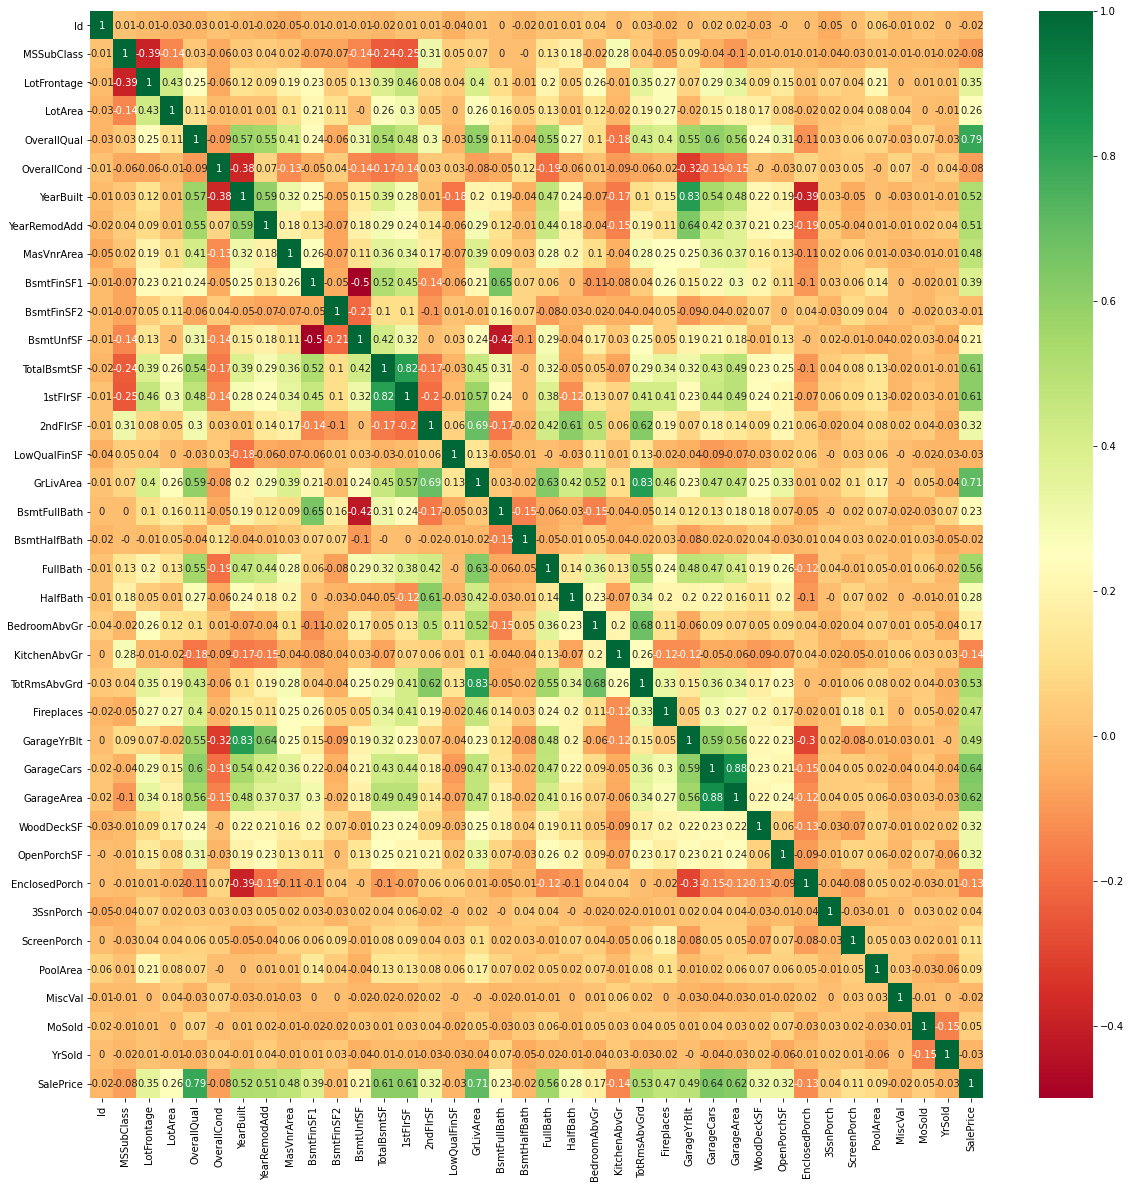

In [5]:
plt.figure(figsize=(20,20))
sns.heatmap(train[quantitative].corr().round(2), annot = True, cmap="RdYlGn")

# Analysing target variable

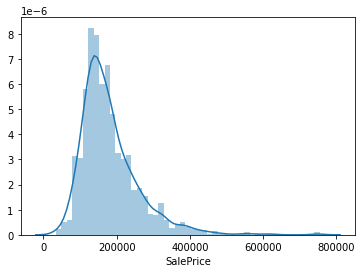

In [6]:
#Analysing SalePrice
sns.distplot(train['SalePrice'])


We can see that the target variable doesn't follow a normal distribution. the distribution is right skewed.

We need to apply log transformation ont this variable. we can use `np.log1p` to perform the transformation

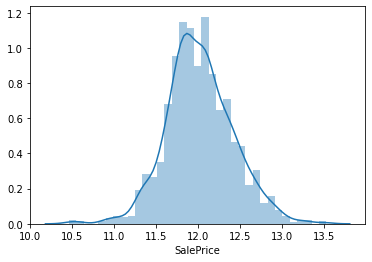

In [7]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'])

In [8]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

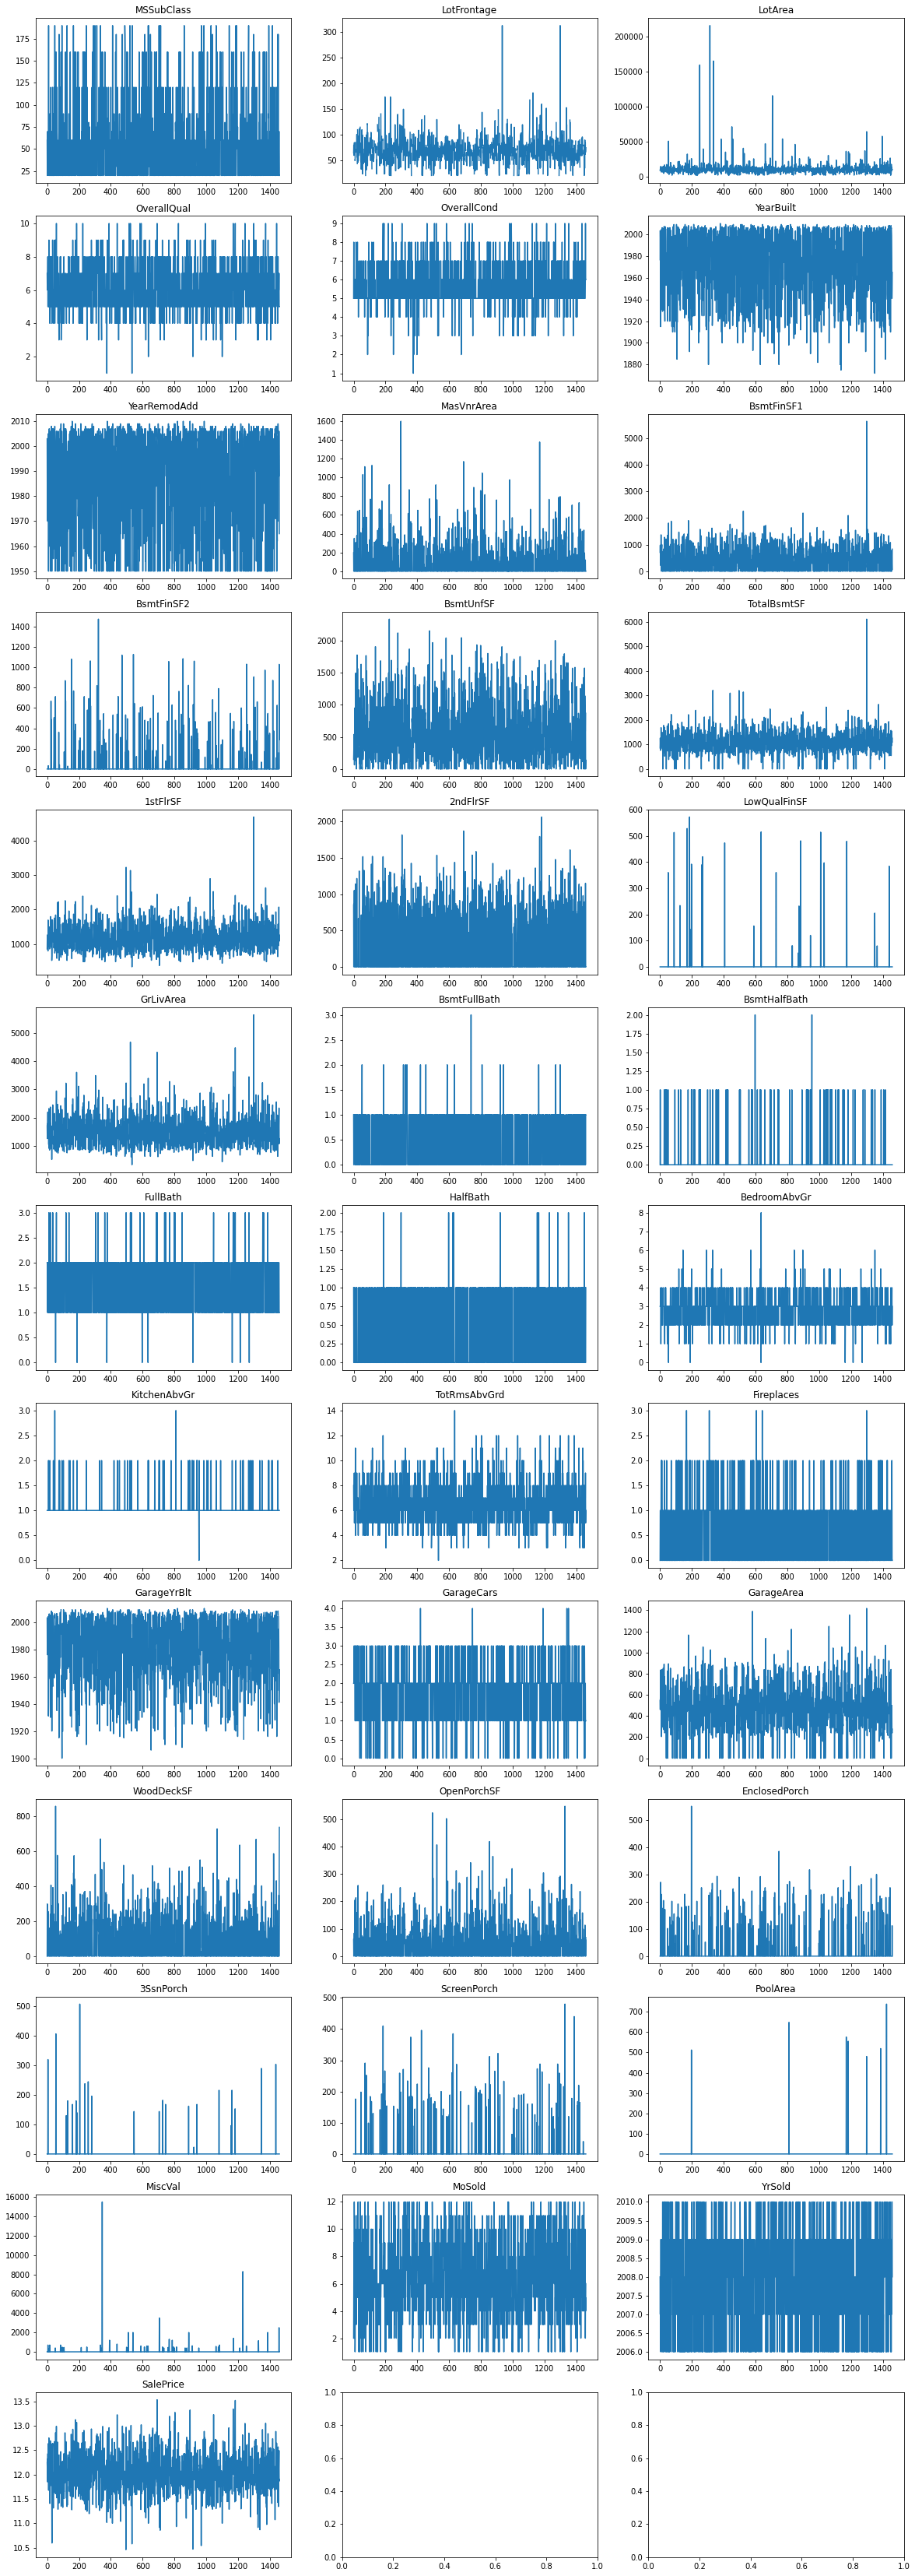

In [9]:
#Analysing features 
fig, ax = plt.subplots(nrows=13, ncols=3,figsize=(20,60),sharex=False, sharey=False)
axis = []
for row in range(13):
    for col in range(3):
        axis.append((row,col))
        
for i,x in zip(quantitative[1::],axis):
    row,col = x
    ax[row,col].plot(train[i])
    ax[row,col].set_title(i)
plt.show()


## Analysing the plots above we can find the following outliers:

#### outliers:
1. LotFrontage > 250
2. LotArea > 200000
3. BsmtFinSF1 > 4500
4. TotalBsmtSF > 5000
5. 1stFlrSF > 4000
6. GrLivArea > 4500
7. EnclosedPorch > 500
8. MiscVal > 4000

#### Dropping outliers from train dataset:

In [10]:
# Drop outliers
dic_outliers = {'LotFrontage':250,'LotArea':200000,'BsmtFinSF1':4500,'TotalBsmtSF':5000, '1stFlrSF':4000, 'GrLivArea':4500, 'EnclosedPorch':500, 'MiscVal':4000}
index_outliers= []
for features in dic_outliers.keys():
    index = list(train[train[features] > dic_outliers[features]].index)
    for i in index:
        if i not in index_outliers:
            index_outliers.append(i)
print(index_outliers)
train.drop(index_outliers,inplace=True)
  

[934, 1298, 313, 523, 197, 346, 1230]


In [11]:
print(train.shape)
print(test.shape)

(1453, 80)
(1459, 79)


### Join train and test datasets to perform the missing values analysis and feature engineering

In [12]:
#Join train and test Datasets
train['train'] = True
test['train'] = False
df = pd.concat([train,test])

In [13]:
#changing type in some features
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].apply(str)
df['MoSold'] = df['MoSold'].apply(str)
df['YearRemodAdd'] = df['YearRemodAdd'].apply(str)

## Missing values imputation

##### Missing values for quantitative features:

In [14]:
# fill missing values for quantitative features
for feature in quantitative[1::]:
    df[feature]=df[feature].fillna(df[feature].mean())   

##### Missing values for special features:

In [15]:
# Some of the houses don't have some of the features bellow, for those we have to change from NaN to None:
features_to_none = ['MiscFeature','Fence','PoolQC','FireplaceQu','Alley']
for featuresNone in features_to_none:
    df[featuresNone]=df[featuresNone].fillna('None')

##### Missing values for qualitative features:

In [16]:
#Fill missing values for the rest of qualitative features
for featuresQual in qualitative:
    df[featuresQual]=df[featuresQual].fillna(df[featuresQual].mode()[0])

In [17]:
df_aux2 = auxiliar_df(df)
numeric_columns2 = list(df_aux2[df_aux2['type']!='object']['columns'])
df_aux2 

,columns,type,missing,size,missing_%
MSSubClass,MSSubClass,object,0,2912,0.0
MSZoning,MSZoning,object,0,2912,0.0
LotFrontage,LotFrontage,float64,0,2912,0.0
LotArea,LotArea,int64,0,2912,0.0
Street,Street,object,0,2912,0.0
Alley,Alley,object,0,2912,0.0
LotShape,LotShape,object,0,2912,0.0
LandContour,LandContour,object,0,2912,0.0
Utilities,Utilities,object,0,2912,0.0
LotConfig,LotConfig,object,0,2912,0.0


## Transform variables with skew over than 0.5 to normal distribution.

you can find the columns name to be transformed bellow:

In [18]:
df_skew_05 = df[numeric_columns2].skew(axis = 0).sort_values(ascending=False)[df[numeric_columns2].skew(axis = 0).sort_values(ascending=False)>0.6]
df_skew_05 = pd.DataFrame(df_skew_05).reset_index()
df_skew_05_list = list(df_skew_05['index'])
df_skew_05_list


['MiscVal',
 'PoolArea',
 'LowQualFinSF',
 '3SsnPorch',
 'LotArea',
 'KitchenAbvGr',
 'BsmtFinSF2',
 'EnclosedPorch',
 'ScreenPorch',
 'BsmtHalfBath',
 'MasVnrArea',
 'OpenPorchSF',
 'WoodDeckSF',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 '2ndFlrSF',
 'TotRmsAbvGrd',
 'Fireplaces',
 'LotFrontage',
 'HalfBath',
 'TotalBsmtSF',
 'BsmtFullBath']

##### We can use the `np.log1p` to perform the transformation

In [19]:
for i in df_skew_05_list:    
    df[i]= np.log1p(df[i])

## Feature engineering

Creating some features to help the model to predict

In [20]:
#Total Floor area of entire house
df['TotalSF']= df['TotalBsmtSF']+ df['1stFlrSF']+ df['2ndFlrSF']

#Total number of baths
df['TotalBath'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

#Total porch area
df['TotalPorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch']+ df['WoodDeckSF']

we have to transform our categorical features in binaries, to do so we can use `pd.get_dummies()`

In [21]:
df_final= pd.get_dummies(df).reset_index(drop=True)

In [22]:
overfit = []
for i in df_final.columns:
    counts = df_final[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df_final) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
df_final = df_final.drop(overfit, axis=1)

### After perform the feature engineering we can split the data as the original data (X_train, X_test)

In [23]:
#Split into training and test dataset from df
X_train = df_final[df_final["train"] ==True]
X_test = df_final[df_final["train"] ==False]

### Defining `X_train`, `X_test`, `y_train`, `y_test`:

In [24]:
X_train = X_train.drop(["train"], axis=1)
X_test = X_test.drop(["train"], axis=1)
X_test = X_test.drop(["SalePrice"], axis=1)
y_test = submission['SalePrice']

In [25]:
y_train = X_train["SalePrice"]
X_train = X_train.drop(["SalePrice"], axis=1)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1453, 372)
(1459, 372)
(1453,)
(1459,)


### Intantiate our model. I will choose lightgbm model

In [27]:
lightgbm = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1
                                       )


In [28]:
lightgbm.fit(X_train,y_train)
y_pred = np.expm1(lightgbm.predict(X_test))


### Evaluating our model

In [29]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
def cv_rmse(model, X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)
score_lightgbm = cv_rmse(lightgbm,X_train)
print("Lightgbm score: {:.4f}".format(score_lightgbm.mean()))

Lightgbm score: 0.1134


### Save into csv file for submission

In [30]:
df = pd.DataFrame({'Id':submission['Id'] ,'SalePrice': y_pred})
df.to_csv('submission2.csv', index=False)